# Time Series Forecasting of Historical Sales Data #

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from pmdarima import auto_arima
import warnings
import holidays

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")


c:\Users\OceanComputers\miniconda3\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Step 1: Data Exploration and Preparation ##

In [2]:
# Load the dataset
file_path = "D:/internship/Retail_Store_Sales_Forecasting/data/retail_sales_mock_data.csv"  
df = pd.read_csv(file_path)

In [3]:
# Convert 'date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalesAmount   48 non-null     int64
 1   Promotion     48 non-null     int64
 2   HolidayMonth  48 non-null     int64
dtypes: int64(3)
memory usage: 1.5 KB
None


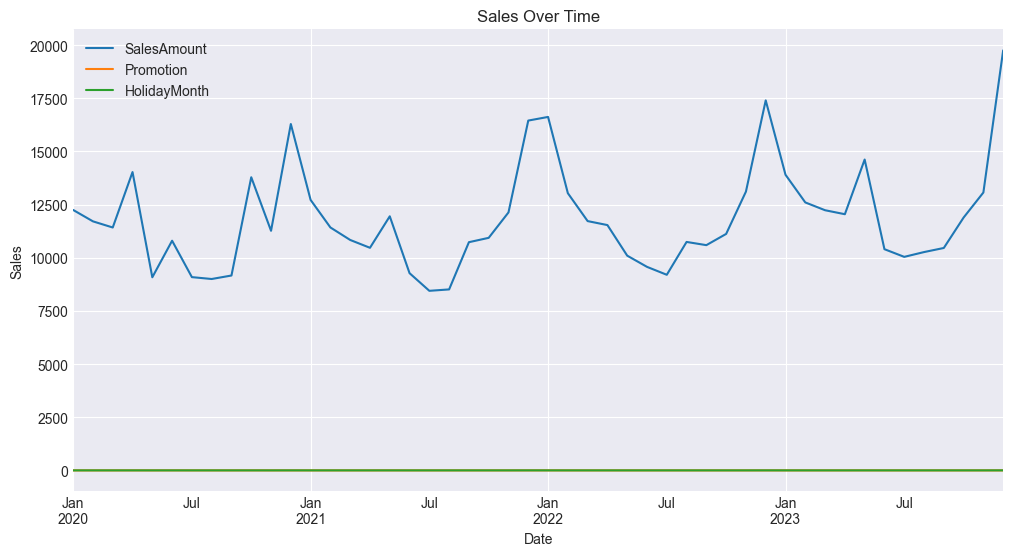

In [4]:
# Initial exploration
print(df.info())
df.plot(title='Sales Over Time', figsize=(12,6))
plt.ylabel('Sales')
plt.show()

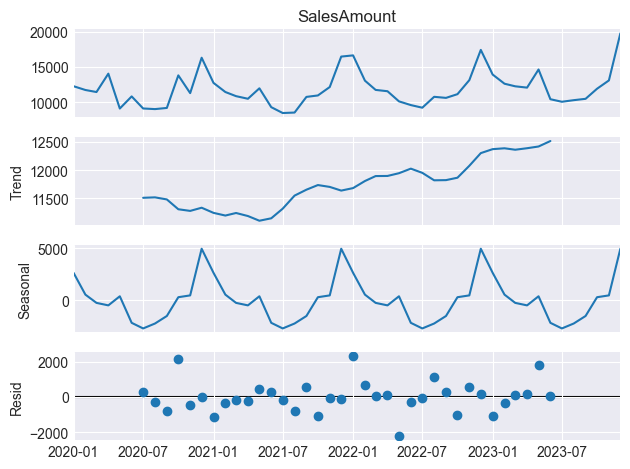

In [5]:
# Decompose time series
decomposition = seasonal_decompose(df['SalesAmount'], model='additive', period=12)
decomposition.plot()
plt.show()


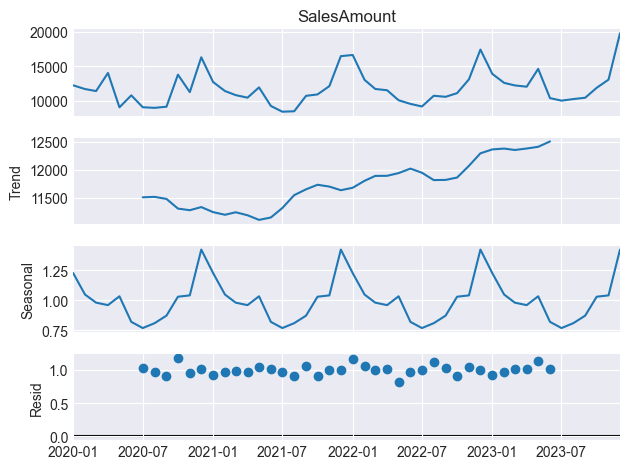

In [6]:
# Decompose time series
decomposition = seasonal_decompose(df['SalesAmount'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

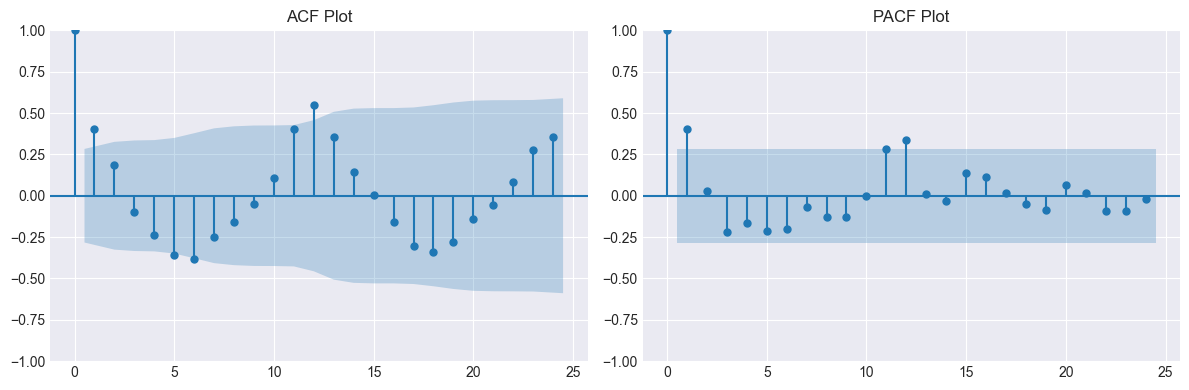

In [7]:
# ACF and PACF plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(df['SalesAmount'], lags=24, ax=plt.gca())
plt.title("ACF Plot")

plt.subplot(1, 2, 2)
plot_pacf(df['SalesAmount'], lags=24, ax=plt.gca(), method='ywm')
plt.title("PACF Plot")

plt.tight_layout()
plt.show()

In [8]:
# ADF Test for stationarity
result = adfuller(df['SalesAmount'])

print("\nDickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

if result[1] < 0.05:
    print("✅ The time series is stationary.")
else:
    print("⚠️ The time series is **not** stationary.")



Dickey-Fuller Test Results:
ADF Statistic: -0.9906636935452957
p-value: 0.7566542548537369
Critical Value 1%: -3.6209175221605827
Critical Value 5%: -2.9435394610388332
Critical Value 10%: -2.6104002410518627
⚠️ The time series is **not** stationary.


In [9]:
# Handle missing values
if df['SalesAmount'].isnull().sum() > 0:
    df['SalesAmount'].interpolate(method='time', inplace=True)

## Step 2: Feature Engineering ##

In [10]:
# Create lag features
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['SalesAmount'].shift(lag)

In [11]:
# Add time-based features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [12]:
# Add holiday indicator (US holidays for example)
us_holidays = holidays.US()
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

In [13]:
df.columns

Index(['SalesAmount', 'Promotion', 'HolidayMonth', 'lag_1', 'lag_2', 'lag_3',
       'day_of_week', 'month', 'is_holiday'],
      dtype='object')

In [14]:
df.head()

,SalesAmount,Promotion,HolidayMonth,lag_1,lag_2,lag_3,day_of_week,month,is_holiday
Date,,,,,,,,,
2020-01-01,12248,0,0,NaN,NaN,NaN,2,1,1
2020-02-01,11712,0,0,12248.0,NaN,NaN,5,2,0
2020-03-01,11423,0,0,11712.0,12248.0,NaN,6,3,0
2020-04-01,14030,1,0,11423.0,11712.0,12248.0,2,4,0
2020-05-01,9082,0,0,14030.0,11423.0,11712.0,4,5,0


In [15]:
# Assume 'economic_index' is present
# df['economic_index'] = df['economic_index'].interpolate()

In [16]:
# Drop NA rows from lagging
df.dropna(inplace=True)

## Step 3: Model Selection and Training ##

### Split data into train and validation ###

In [17]:
# Split data into train and validation (last 6 months for validation)
cutoff = df.index.max() - pd.DateOffset(months=6)
df_train = df[df.index <= cutoff]
df_val = df[df.index > cutoff]

In [18]:
df_train.columns

Index(['SalesAmount', 'Promotion', 'HolidayMonth', 'lag_1', 'lag_2', 'lag_3',
       'day_of_week', 'month', 'is_holiday'],
      dtype='object')

In [19]:
df_val.columns

Index(['SalesAmount', 'Promotion', 'HolidayMonth', 'lag_1', 'lag_2', 'lag_3',
       'day_of_week', 'month', 'is_holiday'],
      dtype='object')

### Model Selection ###

### SARIMA Model (auto_arima for tuning) ###

In [20]:
# SARIMA Model (auto_arima for tuning)
sarima_model = auto_arima(df_train['SalesAmount'],
                          # exogenous=df_train[['economic_index']],
                          seasonal=True,
                          m=7,  # weekly seasonality
                          stepwise=True,
                          suppress_warnings=True,
                          trace=True)

# Forecast SARIMA
sarima_forecast = sarima_model.predict(n_periods=len(df_val))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=718.435, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=711.240, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=710.914, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=844.918, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=713.410, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=713.570, Time=0.12 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=712.504, Time=0.23 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=715.346, Time=0.20 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=715.223, Time=0.20 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=713.780, Time=0.13 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=711.838, Time=0.08 sec
 ARIMA(0,0,2)(0,0,1)[7] intercept   : AIC=710.390, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=711.492, Time=0.05 sec
 ARIMA(0,0,2)(1,0,1)[7] intercept   : AIC=712.325, 

### Prophet model ###

In [21]:
# Reset index to expose the datetime column
df_prophet = df.reset_index()

# Rename columns for Prophet
df_prophet.rename(columns={'Date': 'ds', 'SalesAmount': 'y'}, inplace=True)

# Now safely select required columns 
required_cols = ['ds', 'y', 'is_holiday']

# Subset the DataFrame
#df_prophet_train = df_prophet[df_prophet['ds'] <= cutoff][required_cols]


In [22]:
# 4. Initialize and fit Prophet
model = Prophet()
model.add_regressor('is_holiday')
# model.add_regressor('Promotion')
model.fit(df_prophet)

# Correct way: include 'ds' explicitly
future_val = df_prophet[df_prophet['ds'] > cutoff][['ds', 'is_holiday']]
forecast = model.predict(future_val)

# 7. Evaluate
mae = mean_absolute_error(df_val['SalesAmount'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(df_val['SalesAmount'], forecast['yhat']))
mape = np.mean(np.abs((df_val['SalesAmount'] - forecast['yhat']) / df_val['SalesAmount'])) * 100

print(f"Validation Metrics:")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing


Validation Metrics:
MAE: 441.10, RMSE: 498.13, MAPE: nan%


## Step 4: Model Evaluation and Forecasting ##

In [23]:
# Evaluation metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

In [24]:
# Evaluate SARIMA
mae_sarima, rmse_sarima, mape_sarima = evaluate(df_val['SalesAmount'], sarima_forecast)
print("SARIMA Results:")
print(f"MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%")

SARIMA Results:
MAE: 1997.80, RMSE: 3651.87, MAPE: 12.10%


In [25]:
# Choose best model
best_model = 'Prophet' if rmse_prophet < rmse_sarima else 'SARIMA'
print(f"Best model selected: {best_model}")


NameError: name 'rmse_prophet' is not defined

In [ ]:
# Step 1: Prepare data (ensure no NaN in 'is_holiday')
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'SalesAmount': 'y'})
df_prophet['is_holiday'] = df_prophet['is_holiday'].fillna(0)  # Fill missing

# Step 2: Fit model with regressor
model = Prophet()
model.add_regressor('is_holiday')  # Add holiday flag
model.fit(df_prophet)

# Step 3: Create future dataframe
future = model.make_future_dataframe(periods=180)

# Step 4: Merge 'is_holiday' and handle NaN
future = future.merge(
    df_prophet[['ds', 'is_holiday']].drop_duplicates(),
    on='ds',
    how='left'
)
future['is_holiday'] = future['is_holiday'].fillna(0)  # Critical: Fill future NaN

# Step 5: Predict and plot
forecast = model.predict(future)
model.plot(forecast)

In [ ]:
# Retrain best model on full data
if best_model == 'SARIMA':
    final_model = auto_arima(df['SalesAmount'], seasonal=True, m=7)
    forecast_future = final_model.predict(n_periods=180)
    plt.plot(forecast_future)
    plt.title("SARIMA Forecast")
else:
    prophet_full = Prophet()
    #prophet_full.add_regressor('economic_index')
    prophet_full.add_regressor('is_holiday')
    prophet_full.fit(prophet_df)
    future_full = prophet.make_future_dataframe(periods=180)
    future_full = future_full.merge(df[['is_holiday']], left_on='ds', right_index=True, how='left')
    future_full = prophet_full.make_future_dataframe(periods=180)
    future_full = future_full.merge(df[['is_holiday']], left_on='ds', right_index=True, how='left')

# Fix NaNs in regressors
future_full['is_holiday'].fillna(0, inplace=True)

forecast_future = prophet_full.predict(future_full)

forecast_future = prophet_full.predict(future_full)
prophet_full.plot(forecast_future)
plt.title("Prophet Forecast")
plt.show()
